Total feature importance sum: 1.000000
Morgan Fingerprints importance: 0.793918
Feature Importances from Random Forest Model on Original Features:
                            Feature  Importance
21                 i_qp_RuleOfThree    0.000961
18                      i_qp_#stars    0.001549
13         i_qp_HumanOralAbsorption    0.001763
20                  i_qp_RuleOfFive    0.002437
19                      i_qp_#rotor    0.004993
14  r_qp_PercentHumanOralAbsorption    0.005472
22                      i_qp_#NandO    0.006011
10                     r_qp_accptHB    0.007617
17                      r_qp_EA(eV)    0.009089
6                    r_qp_QPlogPoct    0.009274
0                       r_qp_mol_MW    0.009502
9                      r_qp_donorHB    0.009720
5                     r_qp_CIQPlogS    0.009988
4                       r_qp_QPlogS    0.010079
2                         r_qp_SASA    0.010517
15                   r_qp_QPlogHERG    0.010541
1                       r_qp_volume  

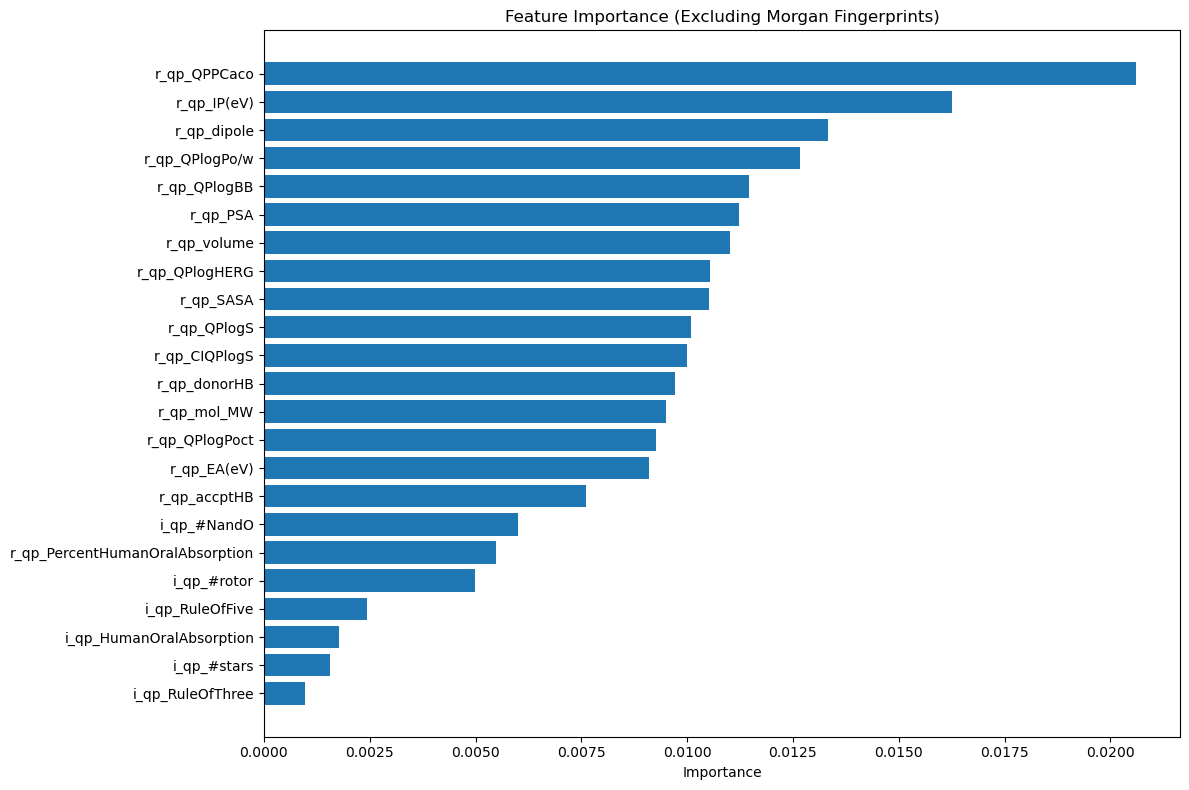

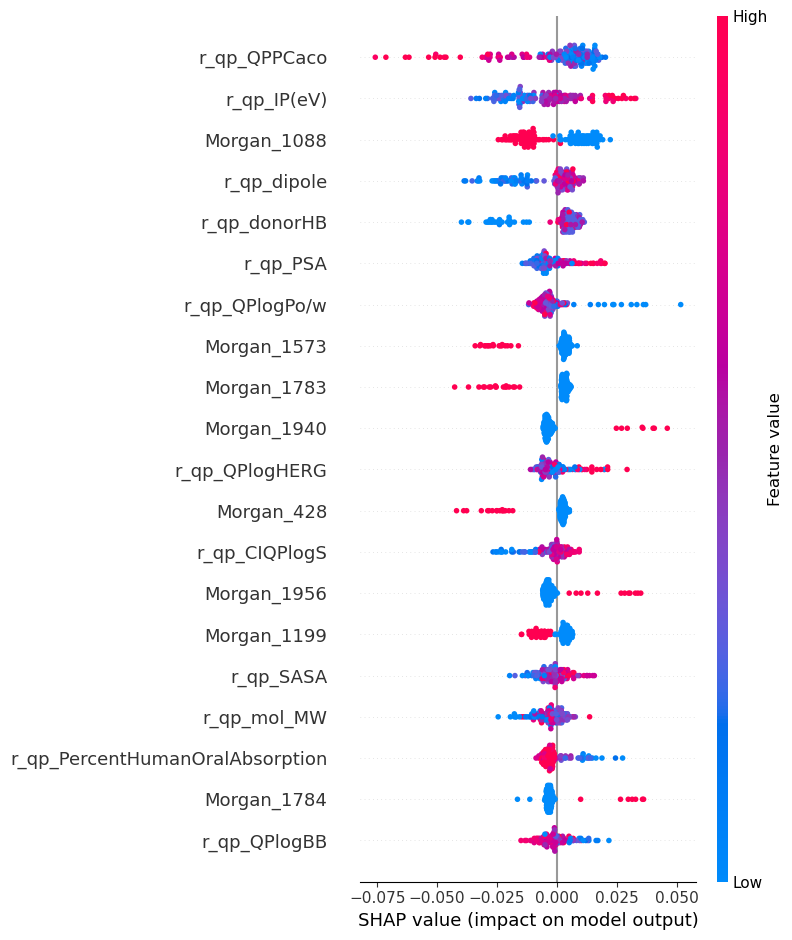

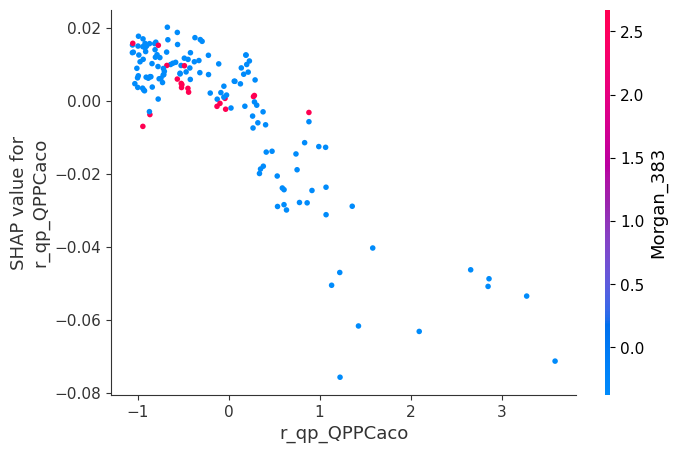

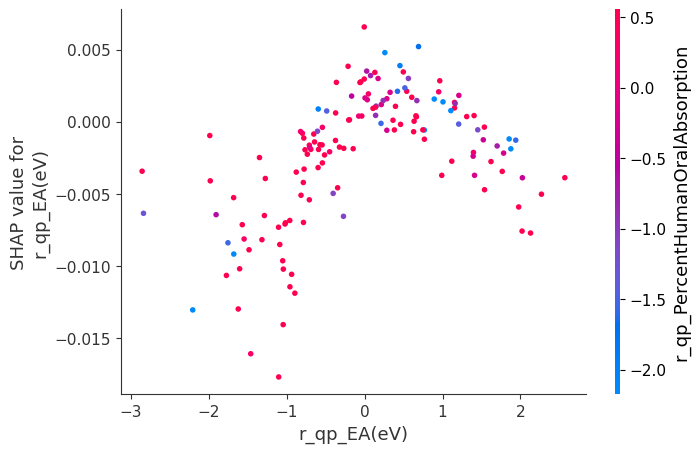

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import PandasTools, rdFingerprintGenerator, DataStructs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import shap

def compute_feature_importance(features, labels, descriptor_labels, morgan_start_index):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(features, labels)

    # Get the feature importances
    importances = rf_model.feature_importances_

    # Separate descriptor and Morgan fingerprint importances
    descriptor_importances = importances[:morgan_start_index]
    morgan_importances = importances[morgan_start_index:]

    # Sum the Morgan fingerprint importance
    morgan_importance_sum = np.sum(morgan_importances)

    # Create DataFrame for descriptor importances
    feature_importance_df = pd.DataFrame({'Feature': descriptor_labels, 'Importance': descriptor_importances})

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

    # Calculate total importance
    total_importance = np.sum(importances)
    print(f"Total feature importance sum: {total_importance:.6f}")
    print(f"Morgan Fingerprints importance: {morgan_importance_sum:.6f}")

    # Print feature importances for insight
    print("Feature Importances from Random Forest Model on Original Features:")
    print(feature_importance_df)

    # Visualize the feature importances (excluding Morgan Fingerprints)
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.title('Feature Importance (Excluding Morgan Fingerprints)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return feature_importance_df, rf_model  # Return rf_model

# Load SDF file and convert to DataFrame
sdf_file = "Structures_759_training.sdf"  
df = PandasTools.LoadSDF(sdf_file, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# List of selected descriptors
selected_columns = [
    'r_qp_mol_MW', 'r_qp_volume', 'r_qp_SASA', 'r_qp_PSA',
    'r_qp_QPlogS', 'r_qp_CIQPlogS', 'r_qp_QPlogPoct', 'r_qp_QPlogPo/w',
    'r_qp_dipole', 'r_qp_donorHB', 'r_qp_accptHB',
    'r_qp_QPPCaco', 'r_qp_QPlogBB', 'i_qp_HumanOralAbsorption',
    'r_qp_PercentHumanOralAbsorption', 'r_qp_QPlogHERG',
    'r_qp_IP(eV)', 'r_qp_EA(eV)',
    'i_qp_#stars', 'i_qp_#rotor', 'i_qp_RuleOfFive', 'i_qp_RuleOfThree', 'i_qp_#NandO'
]

# Calculate Morgan fingerprints
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3)
def calculate_fcfp6(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fcfp6 = morgan_gen.GetFingerprint(mol)
    array = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fcfp6, array)
    return array

# Generate Morgan fingerprints and convert to DataFrame
fcfp6_data = df['SMILES'].apply(calculate_fcfp6)
fcfp6_df = pd.DataFrame(fcfp6_data.tolist(), index=df.index)

# Convert Morgan fingerprints column names to strings
morgan_df_columns = [f'Morgan_{i}' for i in range(fcfp6_df.shape[1])]
fcfp6_df.columns = morgan_df_columns

# Combine descriptors with fingerprints
features = df[selected_columns].join(fcfp6_df).dropna()

# Extract the target variable 'Stable'
target_column = 'Stable'
labels = df[target_column].loc[features.index].astype(int)

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, labels, test_size=0.2, random_state=42
)

# Call feature importance analysis with combined features
feature_importance_df, rf_model = compute_feature_importance(X_train, y_train, selected_columns, len(selected_columns))

# SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values[1], X_test, feature_names=list(features.columns))
shap.dependence_plot('r_qp_QPPCaco', shap_values[1], X_test, feature_names=list(features.columns))
shap.dependence_plot('r_qp_EA(eV)', shap_values[1], X_test, feature_names=list(features.columns))